# The Knapsack Problem

The **Knapsack Problem** is a classic optimization challenge focused on **strategic resource allocation**. It models real-world scenarios where you must select the best combination of items from a set, given a limited budget or capacity.

For example, consider a non-profit organization distributing a fixed budget across various projects. Each project has a **cost** (the funds it requires) and a **value** (its projected social impact). The goal is to choose the portfolio of projects that provides the **maximum possible value** (total social impact) without exceeding the **total budget**.

This cell imports the necessary Python libraries for the project.

In [1]:
# --- General Imports ---
import numpy as np
import time
import math
from math import ceil
from math import pi
import logging

# --- Docplex for Problem Modeling ---
import docplex.mp.model as Model
from docplex.mp.quad import QuadExpr
import docplex.mp.constants as constants

# --- Qiskit Imports ---
from qiskit import transpile
from qiskit.circuit.library import TwoLocal, NLocal, RYGate
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library.standard_gates import get_standard_gate_name_mapping
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService
from qiskit.providers.backend import BackendV2
from qiskit.transpiler import CouplingMap
from qiskit_algorithms.optimizers import NFT
from qiskit_algorithms.utils import algorithm_globals

# --- SciPy for Optimization ---
from typing import Callable, Any, Optional, Tuple, Dict
from scipy.optimize import OptimizeResult, minimize
from scipy.sparse import csr_array

import networkx as nx # Used to create graph structures
import matplotlib.pyplot as plt # For visualizing the graph

# --- (Optional) Numba for performance ---
from numba import jit

## Part I - Problem Definition

This section outlines the setup for our knapsack problem. We begin by defining a problem with **37 items** (`num_items`), generating reproducible random `values` and `weights` for each. The **knapsack capacity** is then set to 40% of the total weight of all items.

Next, we create the optimization model using **binary decision variables** (`x_vars`) to represent the selection of each item (1 if chosen, 0 if not). The **objective function** is designed to maximize the total value, which is framed as a minimization problem by negating the value expression. A crucial **weight constraint** is added to ensure the total weight of the selected items does not exceed the capacity. Finally, the model is exported in the standard LP format for inspection.

In [2]:
# --- 1. Problem Definition for 33 Items ---
num_items = 37

# Generate random data for the items
# We'll use a random seed to make the results reproducible
np.random.seed(33) 
values = np.random.randint(5, 100, size=num_items)
weights = np.random.randint(2, 50, size=num_items)

# Set a reasonable knapsack capacity (e.g., 40% of total weight)
max_weight = int(np.sum(weights) * 0.4)

# --- 2. Create the Docplex Model ---
model = Model.Model(name='knapsack_37_min')
x_vars = model.binary_var_list(num_items, name='x')

# Define the original maximization objective
objective_expr = model.sum(values[i] * x_vars[i] for i in range(num_items))
    
# --- Set the objective to MINIMIZE the NEGATIVE of the original expression ---
model.minimize(-objective_expr)

# Add the weight constraint
constraint_expr = model.sum(weights[i] * x_vars[i] for i in range(num_items))
model.add_constraint(constraint_expr <= max_weight)

print("--- Docplex Model ---")
print(model.export_as_lp_string())

--- Docplex Model ---
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: knapsack_37_min

Minimize
 obj: - 25 x_0 - 12 x_1 - 93 x_2 - 71 x_3 - 23 x_4 - 78 x_5 - 62 x_6 - 72 x_7
      - 66 x_8 - 88 x_9 - 19 x_10 - 47 x_11 - 50 x_12 - 40 x_13 - 38 x_14
      - 82 x_15 - 36 x_16 - 49 x_17 - 17 x_18 - 16 x_19 - 27 x_20 - 85 x_21
      - 85 x_22 - 21 x_23 - 89 x_24 - 93 x_25 - 24 x_26 - 28 x_27 - 78 x_28
      - 88 x_29 - 12 x_30 - 15 x_31 - 72 x_32 - 12 x_33 - 87 x_34 - 86 x_35
      - 8 x_36
Subject To
 c1: 45 x_0 + 45 x_1 + 24 x_2 + 28 x_3 + 34 x_4 + 46 x_5 + 27 x_6 + 16 x_7
     + 32 x_8 + 28 x_9 + 13 x_10 + 3 x_11 + 17 x_12 + 38 x_13 + 35 x_14
     + 13 x_15 + 35 x_16 + 49 x_17 + 17 x_18 + 16 x_19 + 16 x_20 + 30 x_21
     + 42 x_22 + 12 x_23 + 26 x_24 + 46 x_25 + 30 x_26 + 23 x_27 + 44 x_28
     + 10 x_29 + 2 x_30 + 27 x_31 + 15 x_32 + 25 x_33 + 49 x_34 + 48 x_35
     + 41 x_36 <= 418

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= 

### Solving Classically with CPLEX 

We now use the **classical CPLEX solver** to compute the optimal solution by calling `model.solve()`.

Because the objective was framed as minimizing the *negative* total value, the solver returns a negative objective value; its absolute value represents the true maximized value. We then extract the binary decision variables (`x_vars`) to identify which items form this optimal solution.

A final **verification** step confirms that the total value of the selected items matches the maximized objective and that their combined weight does not exceed the knapsack's capacity. 

In [3]:
# --- 3. Solve Classically with Docplex ---
print("\n--- Solving Classically with Docplex ---")
solution = model.solve(log_output=False) 

# Check if a solution was found
if solution:
    # The objective value will be negative. The actual maximized value is its absolute value.
    minimized_objective = solution.objective_value
    maximized_value = -minimized_objective
    
    print(f"Optimal objective value (Minimized Value): {minimized_objective:.2f}")
    
    # Get the values of the decision variables
    x_values = [int(var.solution_value) for var in model.iter_binary_vars()]
    print(f"Optimal x value: {x_values}")
    
    print("\nItems to include in the knapsack (x_i = 1):")
    total_weight = 0
    for i, val in enumerate(x_values):
        if val == 1:
            print(f"  - Item {i}: Value={values[i]}, Weight={weights[i]}")
            total_weight += weights[i]
            
    print(f"\nVerification:")
    print(f"  - Total value of selected items (Maximized Value): {maximized_value:.2f}")
    print(f"  - Total weight of selected items: {total_weight} (Capacity: {max_weight})")

else:
    print(f"❌ No solution found. The problem might be infeasible.")


--- Solving Classically with Docplex ---
Optimal objective value (Minimized Value): -1254.00
Optimal x value: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]

Items to include in the knapsack (x_i = 1):
  - Item 2: Value=93, Weight=24
  - Item 3: Value=71, Weight=28
  - Item 6: Value=62, Weight=27
  - Item 7: Value=72, Weight=16
  - Item 8: Value=66, Weight=32
  - Item 9: Value=88, Weight=28
  - Item 11: Value=47, Weight=3
  - Item 12: Value=50, Weight=17
  - Item 15: Value=82, Weight=13
  - Item 21: Value=85, Weight=30
  - Item 22: Value=85, Weight=42
  - Item 23: Value=21, Weight=12
  - Item 24: Value=89, Weight=26
  - Item 25: Value=93, Weight=46
  - Item 28: Value=78, Weight=44
  - Item 29: Value=88, Weight=10
  - Item 30: Value=12, Weight=2
  - Item 32: Value=72, Weight=15

Verification:
  - Total value of selected items (Maximized Value): 1254.00
  - Total weight of selected items: 415 (Capacity: 418)


## Part II: QUBO Formulation

Next, we transform the constrained `docplex` model into a **QUBO (Quadratic Unconstrained Binary Optimization)** model. This involves creating a single, callable **objective function** (`obj_fn(x)`) that is suitable for heuristic solvers like VQE. This new function combines the original objective with penalties for any constraint violations.

The process involves these key steps:
1.  **Objective Conversion**: The linear objective term is converted into a quadratic form, $x^T Q x + c$. Since our variables are binary ($x_i \in \{0, 1\}$), we know that $x_i^2 = x_i$, allowing us to place the linear coefficients on the diagonal of the $Q$ matrix.
2.  **Constraint Penalization**: The weight constraint is incorporated as a **penalty term**. A violation is measured using a squared hinge loss, $\text{max}(0, \text{total\_weight} - \text{capacity})^2$, which is zero if the constraint is met and grows quadratically otherwise. The penalty is scaled based on the magnitude of the objective function's coefficients to ensure that violating the constraint is always more costly than any potential gain in value.

Finally, we evaluate this function using the optimal classical solution (`x_values`) to verify that, for a feasible solution, its output matches the minimized objective value found by CPLEX.

In [4]:
def model_to_obj(model: Model.Model) -> callable:
    """
    Converts a docplex model into a QUBO objective function with penalties.
    """
    num_vars = model.number_of_binary_variables
    num_ctr = model.number_of_constraints

    # --- 1. Parse the Objective Function ---
    # The model is already minimization, so we parse coefficients directly.
    Q = np.zeros((num_vars, num_vars))
    c = model.objective_expr.get_constant()

    # This loop now correctly gets the linear coefficients for the objective
    for i, dvari in enumerate(model.iter_variables()):
        Q[i, i] = model.objective_expr.linear_part.get_coef(dvari)
    
    # --- 2. Parse Constraints to get A and b for (A @ x - b >= 0) ---
    A = np.zeros((num_ctr, num_vars))
    b = np.zeros(num_ctr)

    for i, ctr in enumerate(model.iter_constraints()):
        # This line is now fixed. 'constants' is defined from the import.
        sense = -1 if ctr.sense == constants.ComparisonType.LE else 1
        for j, dvarj in enumerate(model.iter_variables()):
            A[i, j] = sense * ctr.lhs.get_coef(dvarj)
        b[i] = sense * ctr.rhs.get_constant()

    # --- 3. Define the Penalty and Final Objective Function ---
    max_obj = np.sum(Q, where=Q > 0)
    min_obj = np.sum(Q, where=Q < 0)
    penalty = (max_obj - min_obj) * 1.1 if (max_obj - min_obj) > 0 else 1.1

    @jit
    def obj_fn_embedding_constraints(x):
        # The penalty is applied as you originally designed
        return x @ Q @ x + c + penalty * np.sum(np.maximum(b - A @ x, 0)**2)

    return obj_fn_embedding_constraints

# --- Execute Step 1 ---
obj_fn = model_to_obj(model)

x_arr = np.ascontiguousarray(np.asarray(x_values, dtype=np.float64))
minimized_objectiv_fn = obj_fn(x_arr)
print(f"Optimal objective value (Minimized Value): {minimized_objectiv_fn:.2f}")

Optimal objective value (Minimized Value): -1254.00


## Part III: Quantum Circuit Design

In this section, we design and prepare the **variational quantum circuit (ansatz)**, which is the core of our VQE algorithm.

First, we define the ansatz's structure. The number of qubits, `NUM_QUBITS`, is set to match the number of items in our problem (37). The circuit consists of alternating layers of single-qubit and two-qubit gates:
* A **rotation layer** applies `RY` gates to each qubit, allowing the state to be rotated.
* An **entanglement layer** applies `RXX` gates to couple pairs of qubits. We use a custom **bilinear entanglement** pattern to ensure information can propagate effectively between neighboring qubits.

This entire structure is efficiently constructed using Qiskit's `NLocal` class, with parameters shared across gates of the same type to reduce the optimization complexity.

***

Once designed, the ansatz must be prepared for execution on the `AerSimulator` backend. This involves **transpilation**, a compilation process that optimizes the circuit and maps its abstract gates to the native operations supported by the target simulator. After this optimization, measurement operations are added to all qubits to read out the final state. The resulting circuit is then visualized to provide a clear picture of the gate sequence and entanglement map.

C:\Users\obser\AppData\Local\Temp\ipykernel_9584\2792232767.py:30: DeprecationWarning: The class ``qiskit.circuit.library.n_local.n_local.NLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. This applies to NLocal subclasses too. Use the corresponding function from the module qiskit.circuit.library.n_local instead.
  ansatz = NLocal(num_qubits=NUM_QUBITS, **ansatz_params)


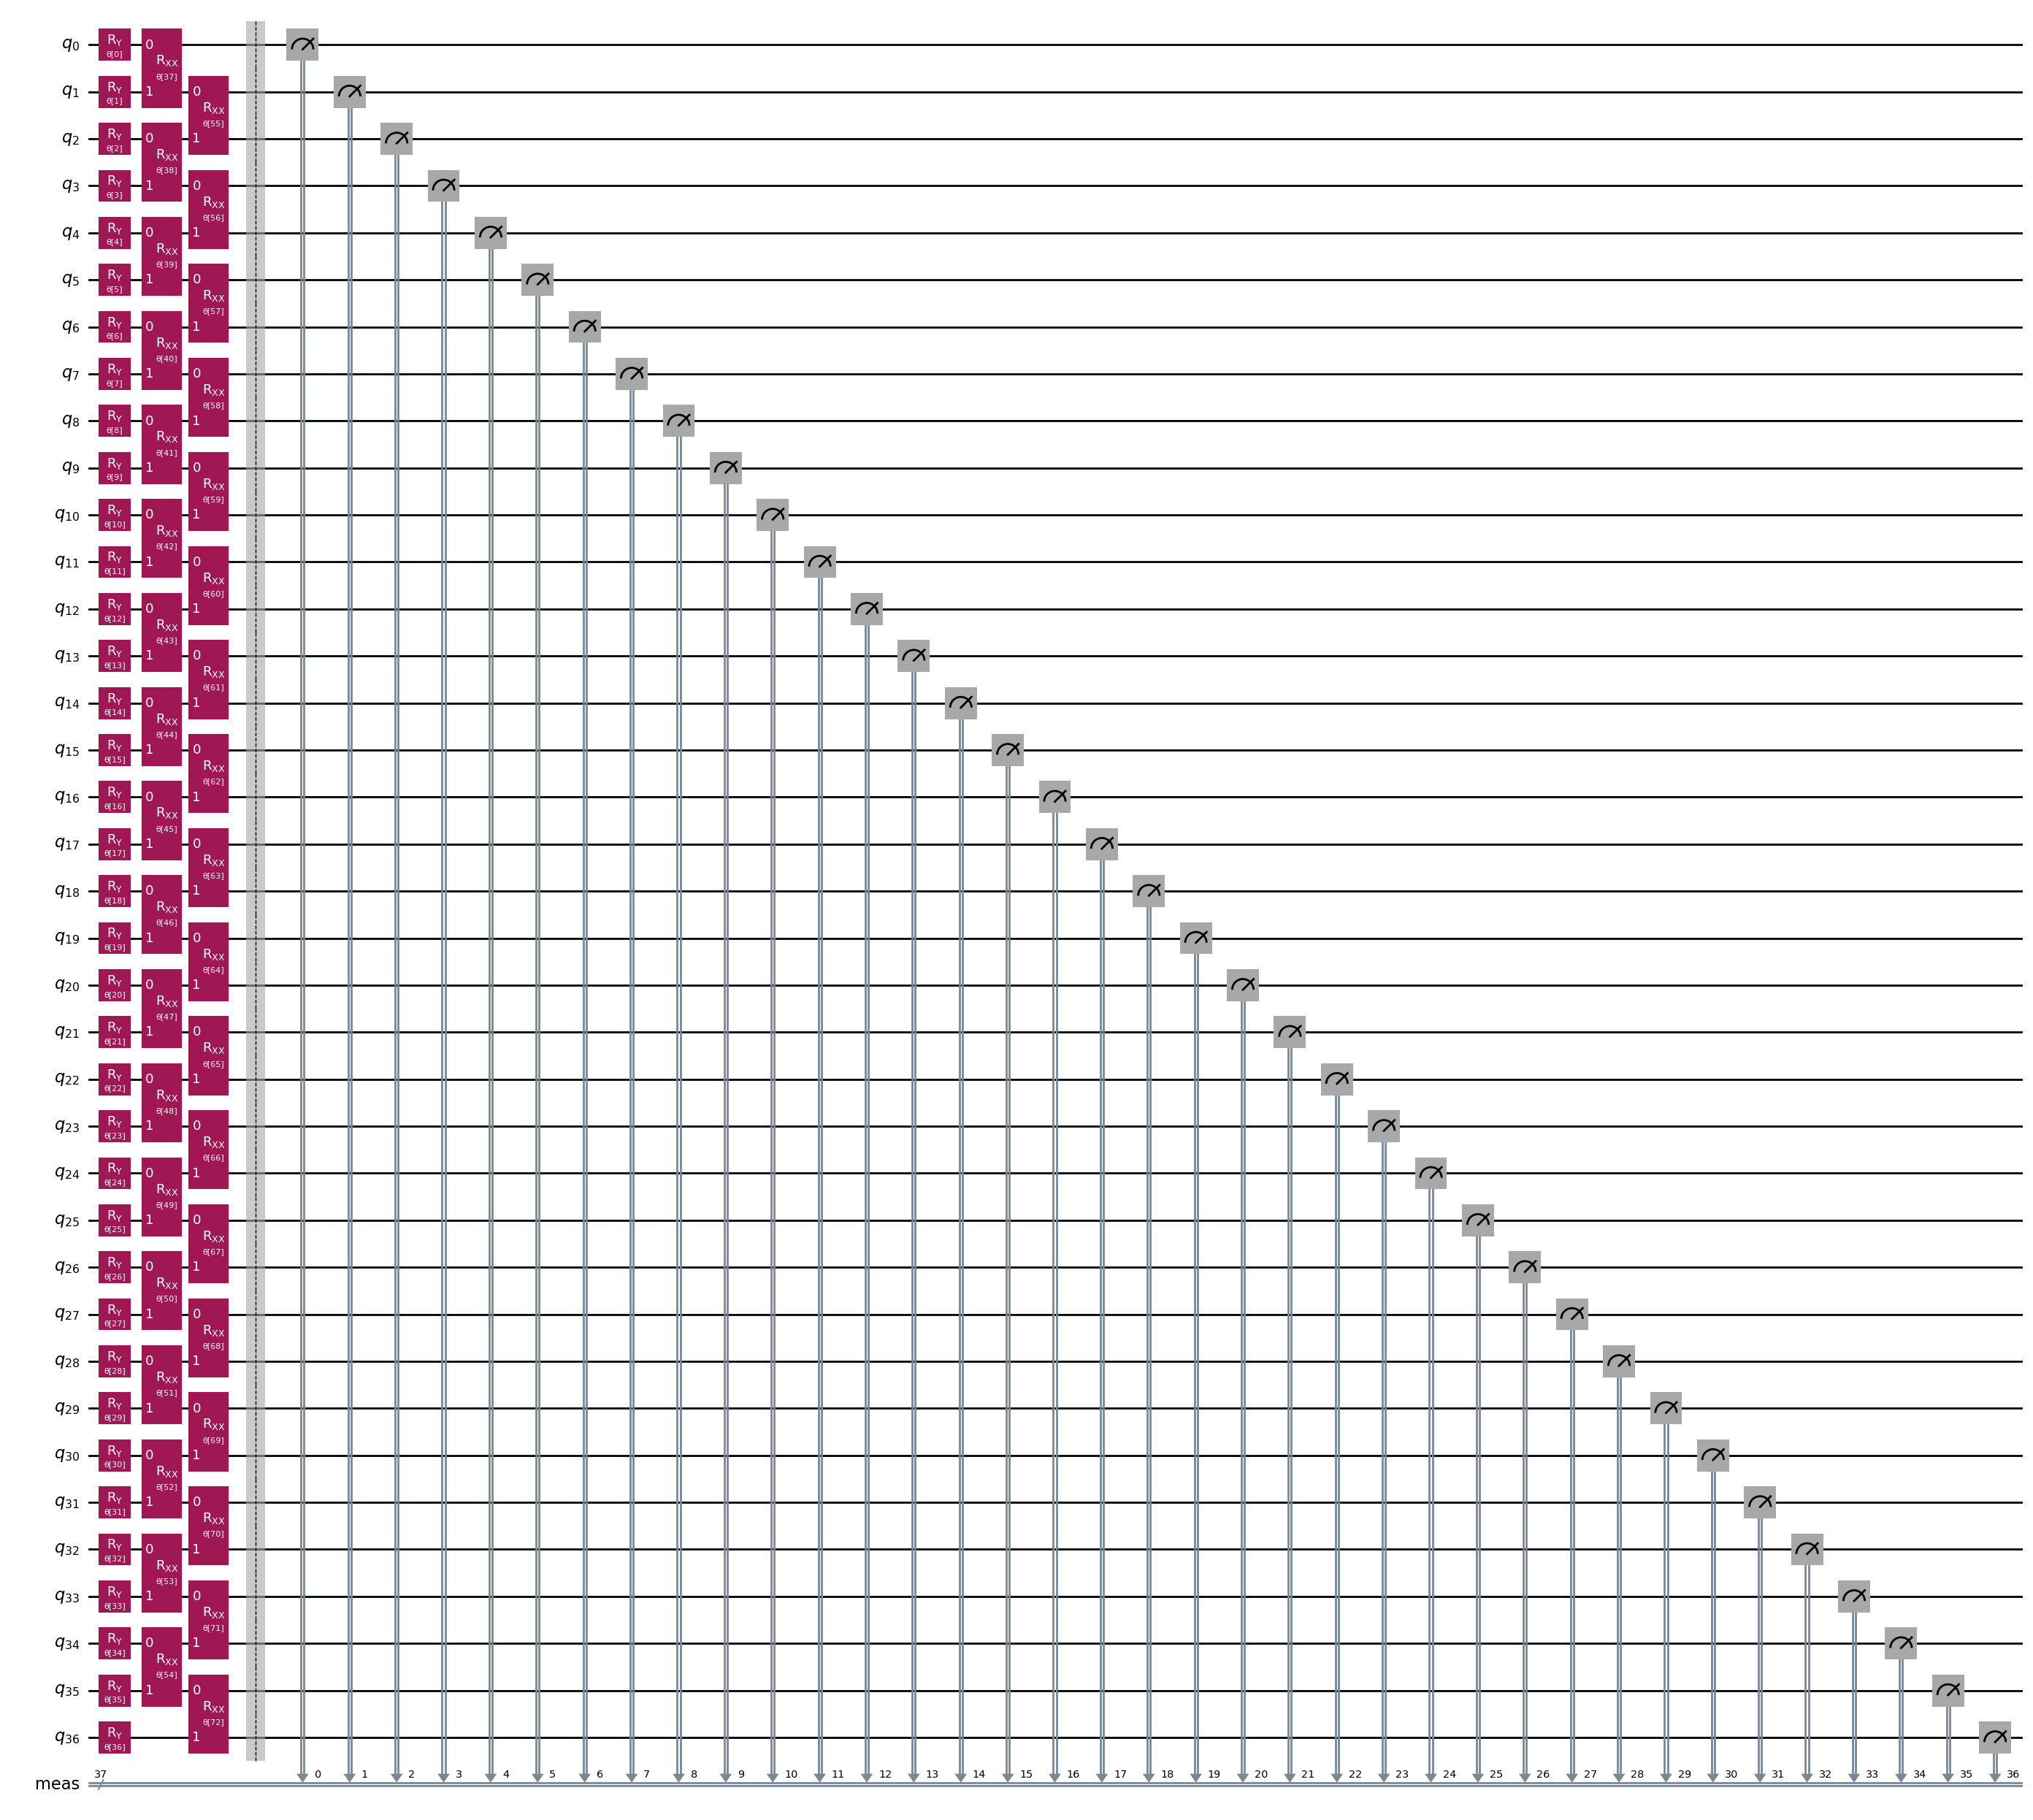

In [5]:
# --- Define Experiment Parameters ---
NUM_QUBITS = num_items
ANSATZ_REPS = 1

# --- 1. Build the Custom Ansatz 

def get_bilinear_entanglement_map(num_qubits):
    entanglement_pairs = [[i, i + 1] for i in range(0, num_qubits - 1, 2)]
    entanglement_pairs += [[i, i + 1] for i in range(1, num_qubits - 1, 2)]
    return entanglement_pairs

rxx_params = ParameterVector(name='p', length=1)
entanglement_block = QuantumCircuit(2)
entanglement_block.rxx(rxx_params[0], 0, 1)

ansatz_params = {
    'rotation_blocks': 'ry',
    'entanglement_blocks': entanglement_block,
    'entanglement': get_bilinear_entanglement_map(NUM_QUBITS),
    'reps': ANSATZ_REPS,
    'skip_final_rotation_layer': True,
    'overwrite_block_parameters': True,
    'flatten': True
}

if isinstance(ansatz_params['rotation_blocks'], str):
    ansatz_params['rotation_blocks'] = get_standard_gate_name_mapping()[ansatz_params['rotation_blocks']]

# Create the ansatz
ansatz = NLocal(num_qubits=NUM_QUBITS, **ansatz_params)

# --- 2. Set up the Backend, Transpile, and add Measurements ---
backend = AerSimulator(method='matrix_product_state')
pass_manager = generate_preset_pass_manager(target=backend.target, optimization_level=3)

# Transpile the purely unitary ansatz
isa_ansatz = pass_manager.run(ansatz)

# Add measurements after transpiling
isa_ansatz.measure_all(inplace=True)

# --- 3. Draw the Compiled Circuit ---
display(isa_ansatz.draw('mpl', fold=-1))

## Part IV: VQE Execution and Optimization

This cell sets up the core components for running our VQE algorithm. The optimization will be guided by the **Conditional Value-at-Risk (CVaR)** metric. By setting `ALPHA = 0.1`, we instruct our objective function to average the costs from the best 10% of measurement outcomes, making the process more robust to statistical noise.

The primary logic is encapsulated in the `cost_function_vqe(theta)` function. For a given set of parameters `theta`, this function:
1.  Executes the quantum circuit for 1024 shots using the `run_counts` helper.
2.  Calculates the objective value for each unique bitstring measured.
3.  Computes the CVaR cost based on the top 10% of these results.
4.  Returns this CVaR cost to the classical optimizer, which works to minimize it.

Crucially, while the optimizer minimizes the CVaR (an average), we also implement **global trackers** to save the **single best bitstring** and its corresponding objective value found across *all* evaluations. This ensures we don't lose the best individual solution discovered during the search. Live progress is printed at each evaluation to monitor both the CVaR cost and the best individual solution's objective value.

In [6]:
# --- Set Seed for Reproducibility ---
algorithm_globals.random_seed = 42

# --- CVaR Parameter ---
ALPHA = 0.1  # Probability for CVaR calculation

# --- Global Trackers for Best Solution ---
evaluation_count = 0
global_best_obj_val = float('inf')
global_best_bitstring = ""

def run_counts(theta: np.ndarray) -> dict:
    """Binds parameters and runs the quantum circuit directly on the backend to get counts."""
    bound_circuit = isa_ansatz.assign_parameters(theta)
    result = backend.run(bound_circuit, shots=1024).result()
    counts = result.get_counts()
    return counts

def cost_function_vqe(theta: np.ndarray) -> float:
    """
    Objective function for the optimizer: calculates CVaR cost, tracks the
    best global solution, and prints progress.
    """
    global evaluation_count, global_best_obj_val, global_best_bitstring
    evaluation_count += 1

    counts = run_counts(theta)
    if not counts:
        print(f"Evaluation {evaluation_count:<4} | Cost: inf (no measurement results)")
        return float('inf')

    # Track the best individual solution globally
    for bits in counts.keys():
        x = np.array(list(bits[::-1]), dtype=float)
        obj_val = obj_fn(x)
        if obj_val < global_best_obj_val:
            global_best_obj_val = obj_val
            global_best_bitstring = bits

    # Calculate CVaR cost for this evaluation
    vals = np.array(
        [(obj_fn(np.array(list(bits[::-1]), dtype=float)), count) for bits, count in counts.items()],
        dtype=[('fx', float), ('cnt', int)]
    )
    vals.sort(order='fx')

    total_shots = int(vals['cnt'].sum())
    cvar_shots = max(1, int(np.ceil(total_shots * ALPHA)))

    cvar_sum = 0.0
    shots_counted = 0
    for fx, cnt in vals:
        take = min(cnt, cvar_shots - shots_counted)
        cvar_sum += fx * take
        shots_counted += take
        if shots_counted >= cvar_shots:
            break
    cvar_cost = cvar_sum / cvar_shots if cvar_shots > 0 else float('inf')
    
    # Print live progress
    print(f"Evaluation {evaluation_count:<4} | Cost (CVaR): {cvar_cost:.6f} | Global Best Obj: {global_best_obj_val:.2f}")

    return cvar_cost

### Custom NFT Optimizer

This cell contains the implementation of our custom optimizer, which is based on the **NFT (Nakanishi-Fujii-Todo) algorithm** [1][2]. It's a lightweight **coordinate descent** method that iterates through each parameter one at a time. The logic is split into a helper function for calculating updates and a main loop that applies them.

#### The Update Rule: `_nft_update`
The core of the optimizer is the `_nft_update` function, which estimates the optimal update for a single parameter, $\theta_k$. It works by probing the objective function at three points: $f(\theta_k)$, $f(\theta_k + \pi/2)$, and $f(\theta_k - \pi/2)$. Based on a **phase interpolation** method, it then calculates the recommended update step $\Delta\theta_k$ using the following rule:

$$\Delta \theta_k = \arctan(r) + \frac{\pi}{2} + \frac{\pi}{2}\text{sign}(\text{denominator})$$

where $r$ is a ratio derived from the three objective values. This approach cleverly uses the three samples to estimate the location of the parameter's local minimum.

#### The Optimizer Loop: `nft_minimize`
The main `nft_minimize` function orchestrates the optimization. It loops through all parameters for a set number of `max_epoch`. In each step, it calls `_nft_update` for a given parameter to get the suggested update $\Delta\theta_k$ and only applies it if its magnitude exceeds a defined `update_threshold`. This prevents tiny, unproductive steps. The optimizer also features an **early-stopping** mechanism, using a `patience` parameter to terminate the run if a certain number of consecutive evaluations yield no improvement in the objective function.

In [7]:
# HELPER FUNCTION
def _nft_update(val0, val1, val2, eps):
    """Parameter update based on the NFT scheme."""
    z0, z1, z3 = val0, val1, val2
    z2 = z1 + z3 - z0
    denominator = (z0 - z2) + eps * (z0 == z2)
    if z1 == z3 or denominator == 0:
        r = 0.0
    else:
        r = (z1 - z3) / denominator
    dw = np.arctan(float(r))
    dw += np.pi / 2 + np.pi / 2 * np.sign(denominator)
    return dw
    
# OPTIMIZER
def nft_minimize(
    fun: Callable[..., Any],
    x0: np.ndarray,
    args: tuple = (),
    max_epoch: int = 4,
    random_update: bool = True,
    **solver_options: dict,
) -> OptimizeResult:
    """
    Custom NFT optimizer enhanced with a patience-based stopping condition.
    """
    n_params = len(x0)
    theta = np.copy(x0)

    # Hyperparameters
    update_epsilon = solver_options.get("update_epsilon", 1e-32)
    update_threshold = solver_options.get("update_threshold", 0.01)
    patience = solver_options.get("patience", 20)
    tol = 1e-6 # Improvement tolerance

    # Counters and trackers
    nit = nfev = 0
    upd = 0.0
    val0 = None
    best_fun_val = np.inf
    consecutive_no_improvement = 0

    for epoch in range(max_epoch):
        idx_set = np.random.permutation(n_params) if random_update else np.arange(n_params)
        
        for k in idx_set:
            if upd != 0.0 or val0 is None:
                val0 = fun(theta, *args)
                nfev += 1

                if val0 < best_fun_val - tol:
                    best_fun_val = val0
                    consecutive_no_improvement = 0
                else:
                    consecutive_no_improvement += 1
            
            if consecutive_no_improvement >= patience:
                break

            theta_1, theta_2 = np.copy(theta), np.copy(theta)
            theta_1[k] += np.pi / 2
            val1 = fun(theta_1, *args)
            nfev += 1
            
            theta_2[k] -= np.pi / 2
            val2 = fun(theta_2, *args)
            nfev += 2

            upd = _nft_update(val0, val1, val2, update_epsilon)
            
            if abs(upd) >= update_threshold:
                theta[k] += upd
                nit += 1
            else:
                upd = 0.0

        if consecutive_no_improvement >= patience:
            break

    result = OptimizeResult()
    result.x = theta
    result.fun = fun(theta, *args) # Final evaluation
    nfev +=1
    result.nit = nit
    result.nfev = nfev
    result.success = True
    if consecutive_no_improvement >= patience:
        result.message = f"Optimization converged: stopped after {patience} evaluations without improvement."
    else:
        result.message = "Optimization terminated successfully after reaching max_epoch."
    return result

### Executing the VQE Run 

This cell brings everything together to run the **VQE optimization**. We begin by defining the **initial parameters** (`initial_theta`) for the ansatz, setting them all to a uniform starting angle of $\pi/3$.

We then configure the key **hyperparameters** for our custom `nft_minimize` optimizer:
* `update_threshold`: The minimum step size for a parameter update to be accepted.
* `patience`: The number of evaluations without improvement before the optimizer stops early.

The optimizer is set to run for a maximum of `max_epoch=4` full passes over all parameters, minimizing the `cost_function_vqe` at each step. Upon completion, a **summary of results** is printed, including the total runtime, the final CVaR value achieved, and the number of function evaluations (`nfev`).

In [8]:
# 1. Define initial parameters
initial_theta = np.full(isa_ansatz.num_parameters, np.pi / 3)

# 2. Set solver options including the new patience parameter
solver_options = {
    "update_threshold": 0.01,
    "update_epsilon": 1e-32,
    "patience": 50 # Stops if cost doesn't improve for 50 evaluations
}

# 3. Call the modified optimizer
print("\n🔥 Starting VQE Optimization with the advanced custom NFT...\n")
t0 = time.time()
result = nft_minimize(
    fun=cost_function_vqe,
    x0=initial_theta,
    max_epoch=4,
    **solver_options
)
t1 = time.time()

# 4. Analyze the optimizer's final results
print(f"\n✅ Optimization Finished in {t1 - t0:.2f}s!")
print(f"Message: {result.message}")
print("\n--- Optimizer Results ---")
print(f"Final CVaR value: {result.fun:.6f}")
print(f"Total parameter updates (nit): {result.nit}")
print(f"Total function evaluations (nfev): {result.nfev}")


🔥 Starting VQE Optimization with the advanced custom NFT...

Evaluation 1    | Cost (CVaR): 648260.598058 | Global Best Obj: -989.00
Evaluation 2    | Cost (CVaR): 256989.048544 | Global Best Obj: -1000.00
Evaluation 3    | Cost (CVaR): 484479.401942 | Global Best Obj: -1038.00
Evaluation 4    | Cost (CVaR): 200191.596117 | Global Best Obj: -1038.00
Evaluation 5    | Cost (CVaR): 12934.017476 | Global Best Obj: -1038.00
Evaluation 6    | Cost (CVaR): 23263.535922 | Global Best Obj: -1043.00
Evaluation 7    | Cost (CVaR): 2480.922330 | Global Best Obj: -1043.00
Evaluation 8    | Cost (CVaR): 1123.376699 | Global Best Obj: -1043.00
Evaluation 9    | Cost (CVaR): 91094.992233 | Global Best Obj: -1043.00
Evaluation 10   | Cost (CVaR): 687.489320 | Global Best Obj: -1069.00
Evaluation 11   | Cost (CVaR): -783.087379 | Global Best Obj: -1069.00
Evaluation 12   | Cost (CVaR): -778.650485 | Global Best Obj: -1069.00
Evaluation 13   | Cost (CVaR): -794.097087 | Global Best Obj: -1069.00
Evalua

### Analyzing the VQE Solution ✅

This final cell reports on and verifies the best bitstring found by the VQE algorithm. First, we report the **objective function value** by passing the solution to `obj_fn(vqe_solution)`. This value includes any penalties and represents the final cost as seen by the optimizer.

To translate this back to the original problem's context, we then calculate the actual **total value** and **total weight** using the initial `values` and `weights`. Finally, a **feasibility check** (`vqe_weight <= max_weight`) is performed to confirm that the solution satisfies the knapsack's capacity constraint.

In [9]:
# Convert the best bitstring found globally to a NumPy array
vqe_solution = np.array([int(bit) for bit in global_best_bitstring[::-1]], dtype=np.float64)

# Call the objective function with the VQE result
vqe_objective_value = obj_fn(vqe_solution)

print(f"\nObjective function value for chosen VQE solution: {vqe_objective_value:.2f}")

# Calculate the value and weight based on the original problem definition
vqe_value = np.sum(vqe_solution * values)
vqe_weight = np.sum(vqe_solution * weights)

print(f"\nVerification of Best Overall VQE solution:")
print(f"  - Best binary string: {vqe_solution.astype(int).tolist()}")
print(f"  - Total value: {vqe_value}")
print(f"  - Total weight: {vqe_weight} (Capacity: {max_weight})")

if vqe_weight <= max_weight:
    print("  - ✅ Constraint SATISFIED.")
else:
    print("  - ⚠️  Constraint VIOLATED.")


Objective function value for chosen VQE solution: -1254.00

Verification of Best Overall VQE solution:
  - Best binary string: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
  - Total value: 1254.0
  - Total weight: 415.0 (Capacity: 418)
  - ✅ Constraint SATISFIED.


Finally, let's directly compare the optimal solution found by the classical CPLEX solver with the best solution discovered by our VQE algorithm.

In [10]:
print(f" quantum solution: ")
print(vqe_solution.astype(int).tolist())
print(f" classical solution: ")
print(x_values)

 quantum solution: 
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
 classical solution: 
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]


[1] K. M. Nakanishi, K. Fujii, and S. Todo, “Sequential minimal optimization for quantum-classical hybrid algorithms,” Phys. Rev. Research, vol. 2, p. 043158, 2020. (arXiv:1903.12166).

[2] WISER Optimization VG (code repository), https://github.com/bimehta/WISER_Optimization_VG (accessed Sep. 13, 2025).